In [2]:
# Import packages as needed. Maybe PIL?
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import YAArrow

import numpy as np

import textwrap

from astropy.io import ascii, fits
from astropy.io.fits import getdata

In [58]:
def spectraChart():
    
    # set up figure 
    f, axs = plt.subplots(8, sharex = True, figsize=(20,40))
    f.set_facecolor('white')
    f.canvas.set_window_title("Spectra")

    plt.style.use('fivethirtyeight')
    
    xmin = 0.2
    xmax = 1.1
    axs[-1].set_xlim(xmin,xmax)
    axs[-1].set_xticks(np.arange(xmin, xmax, .1))
    axs[-1].set_xlabel('Wavelength ($\mu m$)')
    axs[0].set_title("Spectra")
    
    # ordering the plots (0 is the top)
    quasarPlt = 0
    galPlt = 1
    starPlt = 2
    dustPlt = 3
    solPlt = 4
    skyAbsPlt = 5
    skyEmmPlt = 6 
    #solAtPlt = 7
    sdssPlt = 7
    
    
    # SDSS filters
    sdssU = ascii.read('u.dat') 
    sdssG = ascii.read('g.dat')
    sdssR = ascii.read('r.dat')
    sdssI = ascii.read('i.dat')
    sdssZ = ascii.read('z.dat')
    
    axs[sdssPlt].set_ylabel("SDSS Filter Response")
    
    axs[sdssPlt].plot(sdssU['col1']*10**-4,sdssU['col2'],'#008fd5',label='u')
    axs[sdssPlt].plot(sdssG['col1']*10**-4,sdssG['col2'],'#6d904f',label='g')
    axs[sdssPlt].plot(sdssR['col1']*10**-4,sdssR['col2'],'#fc4f30',label='r')
    axs[sdssPlt].plot(sdssI['col1']*10**-4,sdssI['col2'],'#a90548',label='i')
    axs[sdssPlt].plot(sdssZ['col1']*10**-4,sdssZ['col2'],'#810f7c',label='z')
    
    axs[sdssPlt].plot(sdssU['col1']*10**-4,sdssU['col4'],'#008fd5',linestyle='--',label='u')
    axs[sdssPlt].plot(sdssG['col1']*10**-4,sdssG['col4'],'#6d904f',linestyle='--',label='g')
    axs[sdssPlt].plot(sdssR['col1']*10**-4,sdssR['col4'],'#fc4f30',linestyle='--',label='r')
    axs[sdssPlt].plot(sdssI['col1']*10**-4,sdssI['col4'],'#a90548',linestyle='--',label='i')
    axs[sdssPlt].plot(sdssZ['col1']*10**-4,sdssZ['col4'],'#810f7c',linestyle='--',label='z')
    
    handles, labels = axs[sdssPlt].get_legend_handles_labels()
    extra = YAArrow((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    newLabels, newHandles = ["Solid: airmass 1.3\nDashed: no airmass"], [extra]
    for handle, label in zip(handles, labels):
      if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
    axs[sdssPlt].legend(newHandles, newLabels,loc='best')

    
    
    # Sky Spectra
    axs[skyEmmPlt].set_ylabel("Sky Emission (Flux)")
    skyEmmTab = ascii.read('SDSS_sky_emission_spectrum.csv')
    skyEmm = skyEmmTab[(skyEmmTab['lambda [Angstrom]'] >= xmin*10**4) & (skyEmmTab['lambda [Angstrom]'] <= xmax*10**4)]
    axs[skyEmmPlt].plot(skyEmm['lambda [Angstrom]']*(10**-4),skyEmm['atmospheric_emission [arbitrary flux units]'],'#810f7c') 
    
    axs[skyAbsPlt].set_ylabel("Sky Transparency ($F_{obs}/F_{in}$)")
    skyAbsorbTab = ascii.read('sky_transparency.txt',header_start=4,data_start=6,delimiter=' ')
    skyAbsorb = skyAbsorbTab[(skyAbsorbTab['lam(A)'] >= xmin*10**4) & (skyAbsorbTab['lam(A)'] <= xmax*10**4)]
    axs[skyAbsPlt].plot(skyAbsorb['lam(A)']*(10**-4),100**((-skyAbsorb['E1.0(mag)'])/5),color='#6d904f',label="1.0 Air Mass")
    axs[skyAbsPlt].legend(loc='best')
    
    # Interstellar Dust
    # Y-Axis in magnitude units. Spectral range in Optical.
    dust_spec = ascii.read('IS_dust.txt',header_start=0,data_start=3,delimiter=' ')
    axs[dustPlt].set_ylabel("Dust extinction ($C_{ext}/H$)")
    dust = dust_spec[(dust_spec['lambda'] >= 0.3) & (dust_spec['lambda'] <= 1)]
    axs[dustPlt].plot(dust['lambda'], dust['C_ext/H'],color='#4f4f4f',label='ISM Dust')
    axs[dustPlt].legend(loc='best')
    
    # Galaxy Spectrum
    # Y-Axis in magnitude units. Spectral range in Optical.
    ell_spec = ascii.read('elliptical_template.ascii')
    bulge_spec = ascii.read('bulge_template.ascii')
    sa_spec = ascii.read('sa_template.ascii')
    
    axs[galPlt].set_ylabel("Galaxy Emission (Flux)")
    lambdaGalE = ell_spec['col1']*(10**-4)
    lambdaGalB = bulge_spec['col1']*(10**-4)
    lambdaGalS = sa_spec['col1']*(10**-4)
    axs[galPlt].plot(lambdaGalE,ell_spec['col2'],'#008fd5',label='Elliptical')
    axs[galPlt].plot(lambdaGalB,bulge_spec['col2'],'#6d904f',label='Bulge')
    axs[galPlt].plot(lambdaGalS,sa_spec['col2'],'#fc4f30',label='Spiral')
    axs[galPlt].legend(loc='best')
       
    # Stelar spectra
    axs[starPlt].set_ylabel("Stelar Emission (Flux)")
    k0Tab = ascii.read('m0138V_HD025673_K0.txt')
    f5Tab = ascii.read('m0328V_HD076910_F5.txt')
    b9Tab = ascii.read('m0430V_HD105262_B9.txt')
    k0 = k0Tab[(k0Tab['col1'] >= xmin*10**4) & (k0Tab['col1'] <= xmax*10**4)]
    b9 = f5Tab[(f5Tab['col1'] >= xmin*10**4) & (f5Tab['col1'] <= xmax*10**4)]
    f5 = b9Tab[(b9Tab['col1'] >= xmin*10**4) & (b9Tab['col1'] <= xmax*10**4)]
    axs[starPlt].plot(k0['col1']*10**-4,k0['col2'],'#fc4f30',label='Type K0')
    axs[starPlt].plot(b9['col1']*10**-4,b9['col2'],'#008fd5',label='Type B9')
    axs[starPlt].plot(f5['col1']*10**-4,f5['col2'],'#6d904f',label='Type F5')
    axs[starPlt].legend(loc='best')
    
    # Quasar Spectra
    axs[quasarPlt].set_ylabel("Quasar Emission (Flux)")
    quasarTab = ascii.read('quasar.txt')
    quasar = quasarTab[(quasarTab['Wave'] >= xmin*10**4) & (quasarTab['Wave'] <= xmax*10**4)]
    axs[quasarPlt].plot(quasar['Wave']*10**-4,quasar['FluxD'],'#e5ae38')
    axs[quasarPlt].legend(loc='best')
    
    
    # Solar Spectra
    axs[solPlt].set_ylabel("Solar Emission")
    
    solarTab = ascii.read('wehrli85.txt')
    solar = solarTab[(solarTab['nm'] >= xmin*10**3) & (solarTab['nm'] <= xmax*10**3)]
    axs[solPlt].plot(solar['nm']*10**-3,solar['W/sm/nm'],'#e57738',label="Above Atmosphere")
    
    solarAtmosTab = ascii.read('ASTMG173.csv',header_start=1,data_start=2)
    solarAtmos = solarAtmosTab[(solarAtmosTab['Wvlgth nm'] >= xmin*10**3) & (solarAtmosTab['Wvlgth nm'] <= xmax*10**3)]
    axs[solPlt].plot(solarAtmos['Wvlgth nm']*10**-3,solarAtmos['Etr W*m-2*nm-1'],'#e5ae38',label="Through Atmosphere")
    
    axs[solPlt].legend(loc='best')
    
    # Adding absorption and emission lines
    lines = [.656281,.686719,.759370]
    for p in range(8):
        for l in lines:
            axs[p].axvline(l,linestyle='--',color='#8b8b8b')
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    plt.tight_layout()    
    plt.savefig('spectra.pdf')
    plt.show()

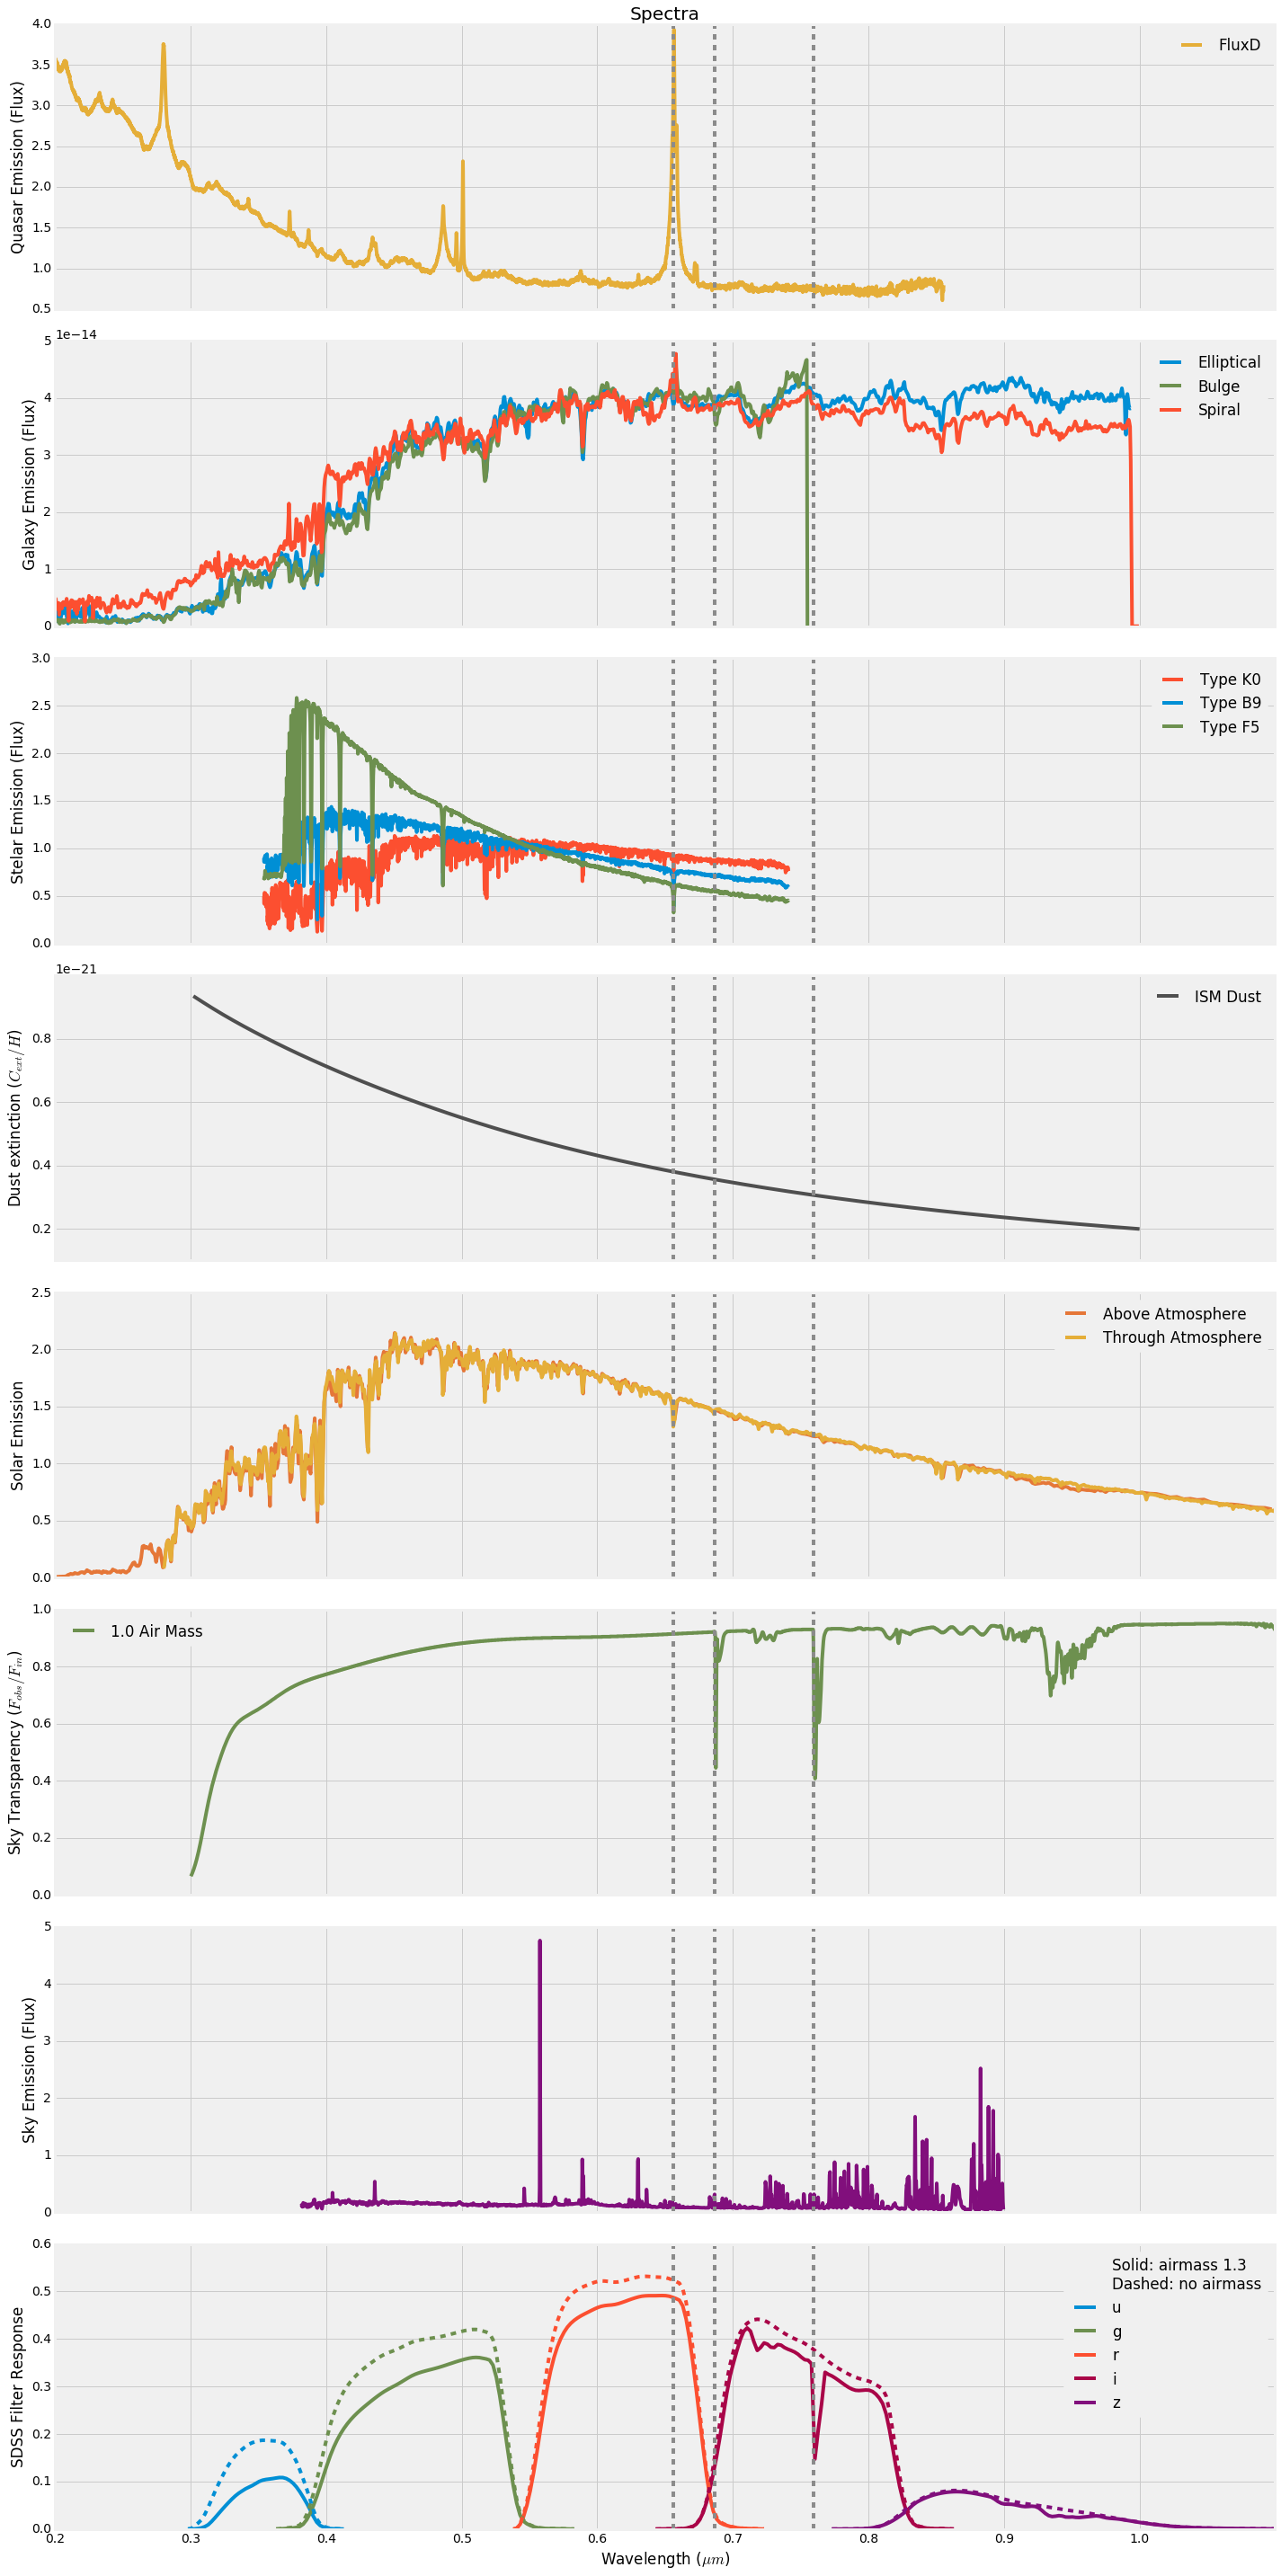

In [59]:
spectraChart()

In [30]:
sdssU = ascii.read('u.dat')  

In [31]:
sdssU

col1,col2,col3,col4,col5
int64,float64,float64,float64,float64
2980,0.0,0.0,0.0,0.0727
3005,0.0001,0.0001,0.0014,0.0992
3030,0.0005,0.0005,0.0071,0.1308
3055,0.0013,0.0013,0.0127,0.1673
3080,0.0026,0.0026,0.0198,0.2075
3105,0.0052,0.0052,0.0314,0.247
3130,0.0093,0.0093,0.0464,0.2862
3155,0.0161,0.0161,0.0629,0.3444
3180,0.024,0.024,0.0794,0.392
